# Denoiser

In [28]:
from denoiser.dsp import convert_audio
from denoiser import pretrained

from scipy.signal import spectrogram

import torchaudio
import torch

import matplotlib.pyplot as plt
import numpy as np

DATA_AUDIO = "./data/30min_presentation.wav"

device = torch.device('cuda')
model = pretrained.dns64().to(device)
wav, sr = torchaudio.load(DATA_AUDIO)

# Convert to mono
wav = wav.mean(0, keepdim=True)

model_sample_rate = model.sample_rate
model_chin = model.chin
print(f"Model sample rate: {model_sample_rate}")
print(f"Model channels in: {model_chin}")

# Data and Model Parallel
wav = wav.to(device)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5])

Model sample rate: 16000
Model channels in: 1


In [36]:
print(f"Running model...")
wav = convert_audio(wav, sr, model_sample_rate, model_chin).to(device)
denoised = model(wav)

print(f"Saving denoised file...")
denoised = denoised.detach().cpu().reshape(-1, 1)
print(f"Denoised shape: {denoised.shape}")

torchaudio.save(DATA_AUDIO, denoised, model_sample_rate)

Running model...
Saving denoised file...
Denoised shape: torch.Size([23838, 1])


Plotting spectrograms...


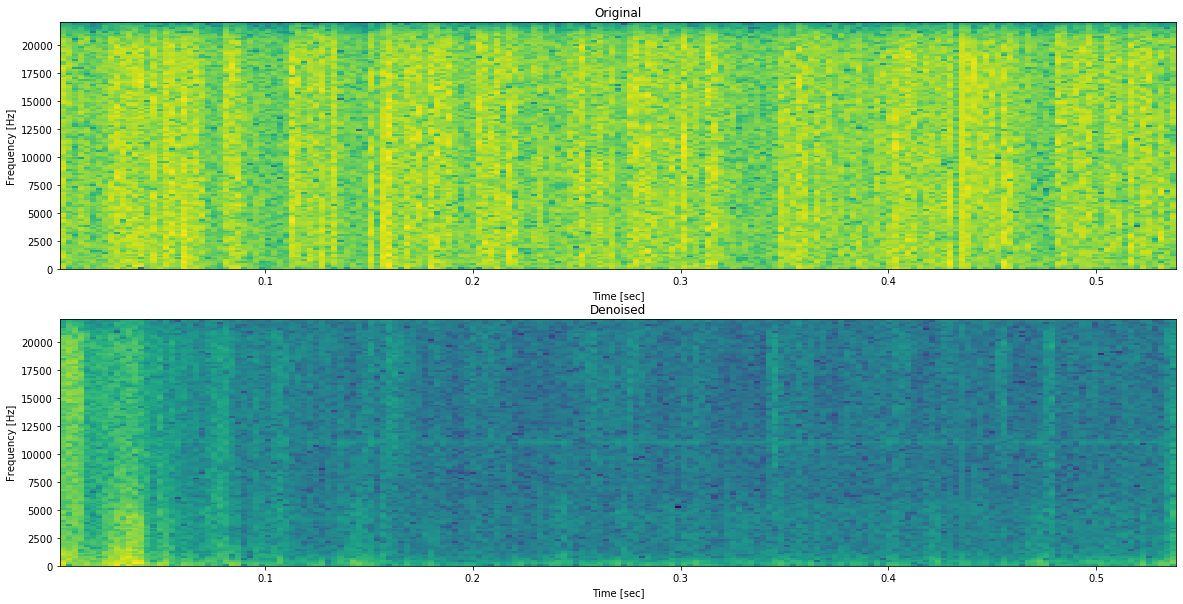

In [37]:
denoised_signal = denoised.cpu().numpy().squeeze()
wav_signal = wav.cpu().numpy().squeeze()

print(f"Plotting spectrograms...")
_, _, spec = spectrogram(wav_signal, sr)
_, _, spec_denoised = spectrogram(denoised_signal, sr)

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.title("Original")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.specgram(wav_signal, Fs=sr)

plt.subplot(2, 1, 2)
plt.title("Denoised")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.specgram(denoised_signal, Fs=sr)

plt.show()

# Speech-To-Text (STT)

In [ ]:
torch.cuda.empty_cache()

del model, denoised

In [5]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from datasets import load_dataset

from jiwer import wer

import numpy as np

import soundfile as sf
import torchaudio
import torch

processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
model = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to('cuda')

ds = load_dataset("kresnik/zeroth_korean", "clean")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

def map_to_pred(batch, sampling_rate: int = 16000):
    inputs = processor(batch["speech"], sampling_rate=sampling_rate, return_tensors="pt", padding="longest")
    input_values = inputs.input_values.to("cuda")
    
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    batch["transcription"] = transcription
    return batch

def audio_to_text(audio):
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding="longest")
    input_values = inputs.input_values.to("cuda")
    
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    return transcription

In [11]:
wav = torchaudio.load('./data/denoised_012.wav')[0].squeeze().numpy()
sf.write('./data/denoised_012.wav', wav, 16000)

texted = []
batch_size = 100000
for i in range(0, len(wav), batch_size):
    batch = wav[i:i+batch_size]
    texted += audio_to_text(batch)

texted = ' '.join(texted)
print(texted)

(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (100000,)
(9506807,) (1